# Definición de la planta

In [1]:
from sympy.abc import s, z
from control import matlab as m
import sympy as sp
import utils.functional as f

gp = 0.3333/(.043*s+1)
gp = gp*12/4
gp

0.9999/(0.043*s + 1)

In [2]:
from utils.units.sympy_helpers import var_in
from utils.units import u, basis

gp = var_in(s, u.rad/u.s, gp)
gp

0.9999/(1 + 0.043*second*s/radian)

In [3]:
nu = basis()
nu

NumericalBasis(mapper=QuantityMapper(salt=5180175076344506255), proxy_system=<UnitSystem: (meter, kilogram, second, ampere, mole, candela, kelvin)>)

## Especificaciones

In [4]:
mp_pi = 5*u.percent
mp_pid = 2*u.percent
ts = 0.45*u.s

In [5]:
def poles_rise_time(p):
    return sp.arg(p)/p.imag

Se define $T$ en función de $t_r$

In [6]:
from utils.ctrlsys import pole_specs
_, dp_s_pid = pole_specs(nu[ts], nu[mp_pid])
tr = nu.to_symb(u.ms, poles_rise_time(dp_s_pid))
dt = tr/10
dt.n(4)

35.31*millisecond

In [7]:
tr.n(5)

353.08*millisecond

In [8]:
from utils.ctrl import expr2sys
gp_tf = expr2sys(nu.to_numeric(gp, as_expr=True), s)
gp_tf

TransferFunction(array([0.9999]), array([0.02297901, 1.        ]))

In [9]:
gp_dtf = m.c2d(gp_tf, nu[dt])
gp_dtf

TransferFunction(array([0.56000733]), array([ 1.        , -0.43993667]), 0.0188686253272992)

Planta discretizada

In [10]:
from utils.ctrl import sys2expr
gp_d = sys2expr(gp_dtf, z)
gp_d

0.560007328424129/(1.0*z - 0.439936665242395)

Planta + atrazo de implementación

In [11]:
gd_d = gp_d * 1/z
gd_d

0.560007328424129/(z*(1.0*z - 0.439936665242395))

# Cálculo de parámetros

In [12]:
gd_dtf = expr2sys(gd_d, z)
gd_dtf.dt = nu[dt]
gd_dtf

TransferFunction(array([0.56000733]), array([ 1.        , -0.43993667,  0.        ]), 0.0188686253272992)

Ley de control para el PI

In [13]:
k_pi, a_pi = sp.symbols("K_{pi} a_{pi}", real=True)
gc_d_pi = k_pi*(z-a_pi)/(z-1)
gc_d_pi

K_{pi}*(-a_{pi} + z)/(z - 1)

Ley de control para el PD

In [14]:
k_pd, a_pd = sp.symbols("K_{pd} a_{pd}", real=True)
gc_d_pd = k_pd*(z-a_pd)/z
gc_d_pd

K_{pd}*(-a_{pd} + z)/z

In [15]:
k_d = sp.symbols("K_{d}", real=True)
gc_d_d = k_d*(z-1)/z
gc_d_d

K_{d}*(z - 1)/z

In [16]:
from utils.ctrlsys import pole_specs
from utils.units.sympy_helpers import split_unit_form
_, dp_s_pi = pole_specs(nu[ts], nu[mp_pi])
split_unit_form(nu.to_symb(u.rad/u.s, dp_s_pi).n(5))

(radian/second)*(-8.6934 + 9.1167*I)

Polos deseados en Z para el controlador PI

In [17]:
from utils.ctrlsys import z_map
dp_pi = z_map(dp_s_pi, nu[dt])
dp_pi

(0.6979015277893713+0.23274528220286603j)

In [18]:
def rlocus_cond(dp, z, fb):
    return fb.subs(z, dp)+1


## Parámetros PI
Parámetros calculados mediante LGR

In [19]:
from utils.math import sp_reim as reim
from utils.sympy_helpers import nsolve

pi_params = nsolve(
    reim(rlocus_cond(dp_pi, z, gd_d*gc_d_pi)),
    {k_pi: 1, a_pi: 1}
)

sp.Dict(pi_params)

{K_{pi}: 0.290892748344366, a_{pi}: 0.146632503479855}

Ajuste "por SISOTOOL"

In [20]:
from utils.ctrlsys import autotune
from utils.misc import valmap

opt_result, pi_tuned_params = autotune(
    valmap(float, pi_params),
    z, m.tf("z"),
    gc_d_pi,
    nu[mp_pi]*.9, nu[ts]*.9,
    gd_dtf,
    1, as_dict=True,
    return_optimize_result=True
)

opt_result

    fjac: array([[ 0.86193923, -0.5070116 ],
       [ 0.5070116 ,  0.86193923]])
     fun: array([2.09653128e-12, 8.91148266e-13])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([-5.55988823e-10, -7.53540849e-10])
       r: array([-0.51202444,  0.51096313,  0.51222662])
  status: 1
 success: True
       x: array([0.42622525, 0.32480448])

In [21]:
sp.Dict(pi_tuned_params)

{K_{pi}: 0.426225251191981, a_{pi}: 0.324804476705097}

In [22]:
gc_pi_dtf = expr2sys(gc_d_pi.subs(pi_tuned_params), z)
gc_pi_dtf_nt = expr2sys(gc_d_pi.subs(pi_params), z)

### Respuesta temporal

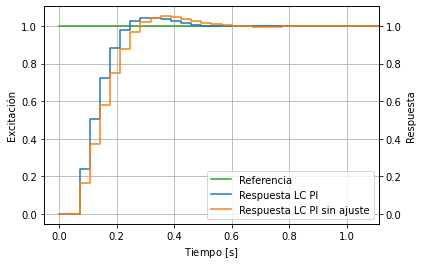

In [23]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp
from utils.mpl import set_datalim

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, 1, 1
)

plot_step(
    m.feedback(gd_dtf*gc_pi_dtf), label="Respuesta LC PI")
plot_step(
    m.feedback(gd_dtf*gc_pi_dtf_nt), label="Respuesta LC PI sin ajuste")
plot_ref(label="Referencia")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
set_datalim(ax_e, x=(0, nu[dt*30]))
ax_e.grid()
set_gain_and_legend_loc(1, "lower right")

In [24]:
gc_pi_dtf = expr2sys(gc_d_pi.subs(pi_tuned_params), z)
gc_pi_dtf

TransferFunction(array([ 0.42622525, -0.13843987]), array([ 1., -1.]), True)

## Parámetros PD

Polos deseados con el controlador PID

In [25]:
_, dp_s_pid = pole_specs(nu[ts], nu[mp_pid])
nu.to_symb(u.rad/u.s, dp_s_pid)

radian*(-8.69338445650699 + 6.98131700797732*I)/second

In [26]:
dp_pid = z_map(dp_s_pid, nu[dt])
sp.sympify(dp_pid)

0.713450180183765 + 0.179515317658922*I

In [27]:
pd_params = nsolve(
    reim(rlocus_cond(dp_pid, z, gd_d*gc_d_pi.subs(pi_tuned_params)*gc_d_pd)),
    {k_pd: -1, a_pd: .5}
)

sp.Dict(pd_params)

{K_{pd}: 0.265559915981418, a_{pd}: -1.48572074190127}

In [28]:
opt_result, pd_tuned_params = autotune(
    valmap(float, pd_params),
    z, m.tf("z"),
    gc_d_pd,
    nu[mp_pid]*.8, nu[ts]*.9,
    gd_dtf*gc_pi_dtf,
    1, as_dict=True, return_optimize_result=True)

opt_result

    fjac: array([[ 0.90755234, -0.41993897],
       [ 0.41993897,  0.90755234]])
     fun: array([-0.00325695, -0.00620776])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 52
     qtf: array([-0.0003489 , -0.00700165])
       r: array([-0.6581598 ,  0.11315997, -0.07702008])
  status: 5
 success: False
       x: array([ 0.25659004, -1.54124565])

In [29]:
sp.Dict(pd_tuned_params)

{K_{pd}: 0.256590042334297, a_{pd}: -1.54124565027532}

In [30]:
gc_pd_dtf = expr2sys(gc_d_pd.subs(pd_tuned_params), z)
gc_pd_dtf

TransferFunction(array([0.25659004, 0.39546829]), array([1., 0.]), True)

In [31]:
gcl_pi_dtf = m.feedback(gd_dtf*gc_pi_dtf)
gcl_pid_dtf = m.feedback(gd_dtf*gc_pi_dtf*gc_pd_dtf)

# Respuesta temporal

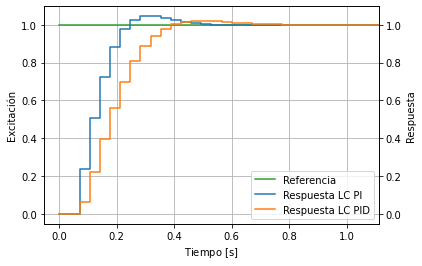

In [32]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, 1, 1
)

#plot_step(m.feedback(gp_tf), label="Respuesta LC sin controlador")
plot_step(gcl_pi_dtf, label="Respuesta LC PI")
plot_step(gcl_pid_dtf, label="Respuesta LC PID")
plot_ref(label="Referencia")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
set_datalim(ax_e, x=(0, nu[dt*30]))
ax_e.grid()
set_gain_and_legend_loc(1, "lower right")

In [33]:
from utils.ctrl import nu_stepinfo

nu_stepinfo(nu, u.s, 1, m.stepinfo(gcl_pid_dtf))

{'RiseTime': 0.211850122305864*second,
 'SettlingTime': 0.388391890894083*second,
 'SettlingMin': 0.943067396726829,
 'SettlingMax': 1.01925695333412,
 'Overshoot': 1.92569533341162*percent,
 'Undershoot': 0,
 'Peak': 1.01925695333412,
 'PeakTime': 0.494316952047015*second,
 'SteadyStateValue': 1.00000000000000}

In [34]:
nu_stepinfo(nu, u.s, 1, m.stepinfo(gcl_pi_dtf))

{'RiseTime': 0.141233414870576*second,
 'SettlingTime': 0.423700244611727*second,
 'SettlingMin': 0.978496951304969,
 'SettlingMax': 1.04499999999790,
 'Overshoot': 4.49999999979034*percent,
 'Undershoot': 0,
 'Peak': 1.04499999999790,
 'PeakTime': 0.282466829741152*second,
 'SteadyStateValue': 1.00000000000000}

# Acción de control

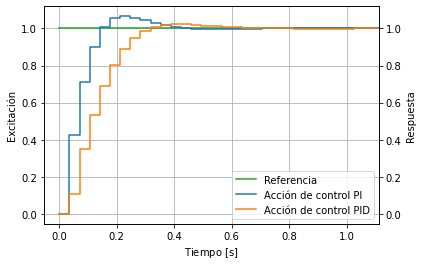

In [35]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, 1, 1
)

plot_step(m.feedback(gc_pi_dtf*gd_dtf/gp_dtf, gp_dtf), label="Acción de control PI")
plot_step(m.feedback(gc_pi_dtf*gc_pd_dtf*gd_dtf/gp_dtf, gp_dtf), label="Acción de control PID")
plot_ref(label="Referencia")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
set_datalim(ax_e, x=(0, nu[dt*30]))
ax_e.grid()
set_gain_and_legend_loc(1, "lower right")

In [36]:
from utils.ctrlsys import difference_eq
from utils.ratpolys import ratpoly_coeffs
def my_diff_eq(expr, z, u_str="u", e_str="e"):
    return difference_eq(*ratpoly_coeffs(expr, z),
        sp.Function(e_str), sp.Function(u_str), sp.Symbol("k"))

In [37]:
my_diff_eq(gc_d_pi, z, "u_{pi}", "e").subs(pi_tuned_params).n(6)

Eq(u_{pi}(k), 0.426225*e(k) - 0.13844*e(k - 1) + u_{pi}(k - 1))

In [38]:
my_diff_eq(gc_d_pd, z, "u_{pd}", "u_{pi}").subs(pd_tuned_params).n(6)

Eq(u_{pd}(k), 0.25659*u_{pi}(k) + 0.395468*u_{pi}(k - 1))

# Transformando los parámetros pi*pd a pi-d

In [39]:
k_pip, a_pip, k_d, dt_ = sp.symbols("{K_{pi}}' {a_{pi}}' K_d, T")

gc_d_d = (k_d/dt_)*(z-1)/z
gc_d_pimd = gc_d_pi.subs({k_pi: k_pip, a_pi: a_pip})-gc_d_d

gc_d_pimd

-K_d*(z - 1)/(T*z) + {K_{pi}}'*(z - {a_{pi}}')/(z - 1)

In [40]:
from utils.sympy_helpers import solve

pimd_params, = solve(
    sp.Eq(gc_d_pimd, gc_d_pi*gc_d_pd),
    [k_pip, a_pip, k_d]
)
sp.Dict(pimd_params)

{K_d: -K_{pd}*K_{pi}*T*a_{pd}*a_{pi}, {K_{pi}}': K_{pd}*K_{pi}*(-a_{pd}*a_{pi} + 1), {a_{pi}}': (2*a_{pd}*a_{pi} - a_{pd} - a_{pi})/(a_{pd}*a_{pi} - 1)}

In [41]:
from utils.functional import fpartial as fp, Functional as f
from utils.units import to_basis
from sympy.physics.units.systems import SI

to_basis = fp(to_basis, SI)
subs = fp(lambda vars, x: x.subs(vars))
N = fp(sp.N)

sp.Dict(valmap(
    N.P(n=6) @ to_basis @ subs.P(pi_tuned_params | pd_tuned_params | {dt_: dt}),
    pimd_params
))

{K_d: 0.00193308*second, {K_{pi}}': 0.164114, {a_{pi}}': -0.143432}